# Week 14, Day 2: LSTM Networks for Financial Time Series

## Learning Objectives
1. Understand LSTM cell architecture (forget, input, output gates)
2. Master the memory cell mechanism
3. Learn how LSTMs solve vanishing gradients
4. Implement LSTM in PyTorch for trading
5. Build multi-step ahead prediction models

---

## 1. LSTM Cell Architecture

### The Vanishing Gradient Problem in RNNs

Standard RNNs suffer from vanishing gradients during backpropagation through time (BPTT). When gradients are repeatedly multiplied through many time steps:

$$\frac{\partial L}{\partial h_0} = \frac{\partial L}{\partial h_T} \prod_{t=1}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

If $\left\| \frac{\partial h_t}{\partial h_{t-1}} \right\| < 1$, gradients vanish exponentially.

### LSTM Solution: Gated Memory

Long Short-Term Memory (LSTM) networks, introduced by Hochreiter & Schmidhuber (1997), use a **cell state** $C_t$ as a "highway" for gradient flow, controlled by three gates:

```
                    ┌─────────────────────────────────────┐
                    │           Cell State (Ct)           │
         ×          │    ─────────────────────────────    │         +
    ┌───────┐       │         ↑              ↑            │    ┌───────┐
    │Forget │───────┼─────────┘              │            │────│ tanh  │───→ ht
    │ Gate  │       │                   ┌────┴────┐       │    └───────┘
    └───────┘       │                   │   ×     │       │         ↑
         ↑          │                   │         │       │    ┌────┴────┐
    ┌────┴────┐     │              ┌────┴───┐ ┌───┴────┐  │    │ Output  │
    │  σ(Wf)  │     │              │ Input  │ │ Cand.  │  │    │  Gate   │
    └────┬────┘     │              │  Gate  │ │  Cell  │  │    └────┬────┘
         │          │              └────┬───┘ └───┬────┘  │         │
    [ht-1, xt]      │                   │ σ       │ tanh  │    ┌────┴────┐
                    │              ┌───┴───┐ ┌───┴───┐   │    │  σ(Wo)  │
                    │              │σ(Wi)  │ │tanh(Wc)│   │    └────┬────┘
                    │              └───┬───┘ └───┬───┘   │         │
                    │                  └────┬────┘       │    [ht-1, xt]
                    │                  [ht-1, xt]        │
                    └─────────────────────────────────────┘
```

## 2. The Three Gates: Mathematical Formulation

### 2.1 Forget Gate

Decides what information to **discard** from the cell state:

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

- $f_t \in (0, 1)^d$ — forget gate activation
- $\sigma$ — sigmoid function (outputs between 0 and 1)
- Values close to 0 mean "forget", close to 1 mean "keep"

**Trading Intuition**: Forget outdated market regimes when new information arrives.

### 2.2 Input Gate

Decides what new information to **store** in the cell state:

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

- $i_t$ — input gate activation (which values to update)
- $\tilde{C}_t$ — candidate values to add to the state

**Trading Intuition**: Decide which new price/volume signals are worth remembering.

### 2.3 Cell State Update

Combine forget and input to update the cell state:

$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

- $\odot$ — element-wise (Hadamard) product
- This is the **key innovation**: additive updates allow gradients to flow!

### 2.4 Output Gate

Decides what to **output** based on filtered cell state:

$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \odot \tanh(C_t)$$

- $o_t$ — output gate activation
- $h_t$ — hidden state (actual output at time $t$)

**Trading Intuition**: Filter which learned patterns are relevant for the current prediction.

## 3. How LSTMs Solve Vanishing Gradients

### The Gradient Highway

In standard RNNs, the gradient of the loss with respect to earlier hidden states involves:

$$\frac{\partial h_t}{\partial h_{t-1}} = W^T \cdot \text{diag}(\sigma'(\cdot))$$

Repeated multiplication causes exponential decay.

### LSTM's Additive Cell State

For the cell state gradient:

$$\frac{\partial C_t}{\partial C_{t-1}} = f_t$$

This is just the forget gate value! The gradient can flow unchanged when $f_t \approx 1$.

$$\frac{\partial L}{\partial C_0} = \frac{\partial L}{\partial C_T} \prod_{t=1}^{T} f_t$$

**Key Insight**: When the network learns to set $f_t \approx 1$, gradients propagate across hundreds of time steps without vanishing!

### Constant Error Carousel (CEC)

The cell state acts as a "conveyor belt" (constant error carousel):
- Information can be added via input gate
- Information can be removed via forget gate
- But the path itself doesn't transform the information → no vanishing gradient!

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1


## 4. LSTM Implementation from Scratch (Educational)

Let's implement an LSTM cell from scratch to understand each component:

In [2]:
class LSTMCellFromScratch(nn.Module):
    """
    Educational LSTM cell implementation showing all gates explicitly.
    
    This helps understand the internal mechanics:
    - Forget gate: What to discard from memory
    - Input gate: What new information to store
    - Output gate: What to output from memory
    """
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Combined input dimension: [h_{t-1}, x_t]
        combined_size = input_size + hidden_size
        
        # Gate weights (each gate has its own weights)
        self.W_f = nn.Linear(combined_size, hidden_size)  # Forget gate
        self.W_i = nn.Linear(combined_size, hidden_size)  # Input gate
        self.W_c = nn.Linear(combined_size, hidden_size)  # Candidate cell
        self.W_o = nn.Linear(combined_size, hidden_size)  # Output gate
        
        # Initialize weights (Xavier initialization)
        for module in [self.W_f, self.W_i, self.W_c, self.W_o]:
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
        
        # Bias forget gate towards 1 (remember by default)
        nn.init.ones_(self.W_f.bias)
    
    def forward(self, x_t, h_prev, c_prev):
        """
        Forward pass for one time step.
        
        Args:
            x_t: Input at time t, shape (batch_size, input_size)
            h_prev: Previous hidden state, shape (batch_size, hidden_size)
            c_prev: Previous cell state, shape (batch_size, hidden_size)
            
        Returns:
            h_t: Current hidden state
            c_t: Current cell state
            gates: Dictionary of gate activations for visualization
        """
        # Concatenate input and previous hidden state
        combined = torch.cat([h_prev, x_t], dim=1)
        
        # === FORGET GATE ===
        # Decides what to discard from cell state
        f_t = torch.sigmoid(self.W_f(combined))
        
        # === INPUT GATE ===
        # Decides what new info to store
        i_t = torch.sigmoid(self.W_i(combined))
        
        # === CANDIDATE CELL STATE ===
        # Potential new values to add
        c_tilde = torch.tanh(self.W_c(combined))
        
        # === CELL STATE UPDATE ===
        # c_t = f_t * c_{t-1} + i_t * c_tilde
        c_t = f_t * c_prev + i_t * c_tilde
        
        # === OUTPUT GATE ===
        # Decides what to output
        o_t = torch.sigmoid(self.W_o(combined))
        
        # === HIDDEN STATE ===
        # h_t = o_t * tanh(c_t)
        h_t = o_t * torch.tanh(c_t)
        
        gates = {
            'forget': f_t.detach(),
            'input': i_t.detach(),
            'output': o_t.detach(),
            'candidate': c_tilde.detach()
        }
        
        return h_t, c_t, gates


# Test the cell
batch_size, input_size, hidden_size = 32, 1, 64
cell = LSTMCellFromScratch(input_size, hidden_size)

x = torch.randn(batch_size, input_size)
h = torch.zeros(batch_size, hidden_size)
c = torch.zeros(batch_size, hidden_size)

h_new, c_new, gates = cell(x, h, c)
print(f"Input shape: {x.shape}")
print(f"Hidden state shape: {h_new.shape}")
print(f"Cell state shape: {c_new.shape}")
print(f"\nGate activation ranges:")
for name, gate in gates.items():
    print(f"  {name}: [{gate.min():.3f}, {gate.max():.3f}]")

Input shape: torch.Size([32, 1])
Hidden state shape: torch.Size([32, 64])
Cell state shape: torch.Size([32, 64])

Gate activation ranges:
  forget: [0.637, 0.809]
  input: [0.390, 0.610]
  output: [0.397, 0.609]
  candidate: [-0.398, 0.417]


## 5. Data Preparation for Financial Time Series

Data shape: (1760, 1)
Date range: 2018-01-02 to 2024-12-30
Price range: $33.80 - $257.85


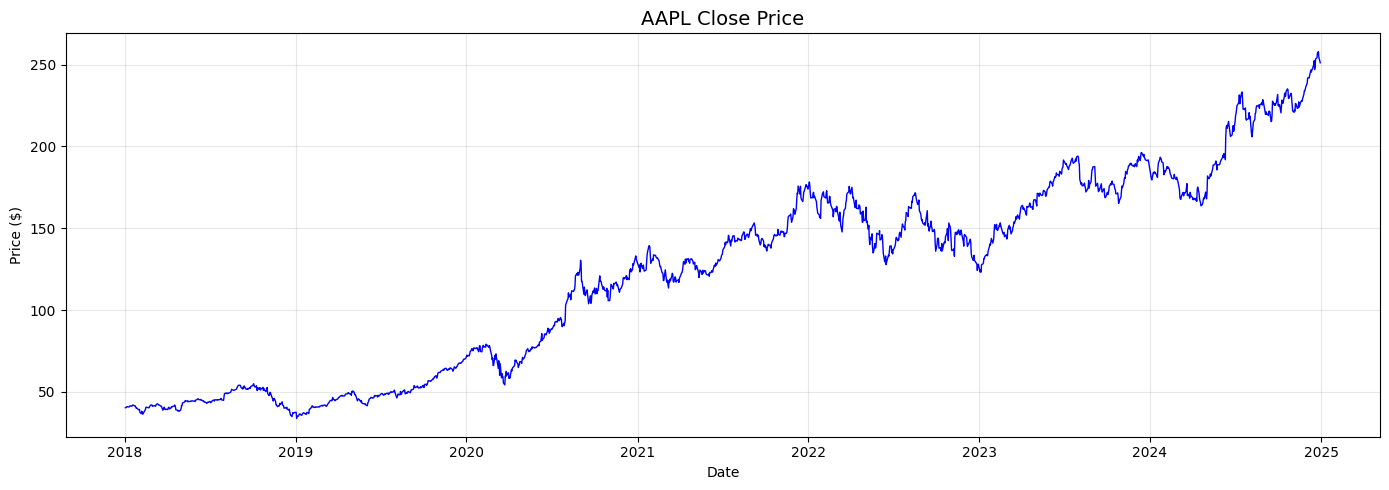

In [3]:
# Download stock data
ticker = 'AAPL'
start_date = '2018-01-01'
end_date = '2024-12-31'

print(f"Downloading {ticker} data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Use Close price
prices = data['Close'].values.reshape(-1, 1)
dates = data.index

print(f"Data shape: {prices.shape}")
print(f"Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}")

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(dates, prices, 'b-', linewidth=1)
plt.title(f'{ticker} Close Price', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
def create_sequences(data, seq_length, forecast_horizon=1):
    """
    Create sequences for LSTM training with multi-step forecasting support.
    
    Args:
        data: Scaled price data (n_samples, n_features)
        seq_length: Number of past time steps to use as input
        forecast_horizon: Number of future steps to predict
        
    Returns:
        X: Input sequences (n_sequences, seq_length, n_features)
        y: Target values (n_sequences, forecast_horizon)
    """
    X, y = [], []
    
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # Input: seq_length days of data
        X.append(data[i:i + seq_length])
        # Target: next forecast_horizon days
        y.append(data[i + seq_length:i + seq_length + forecast_horizon].flatten())
    
    return np.array(X), np.array(y)


# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Parameters
SEQUENCE_LENGTH = 60  # Use 60 days of history
FORECAST_HORIZON = 5  # Predict 5 days ahead

# Create sequences
X, y = create_sequences(prices_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON)
print(f"X shape: {X.shape} (samples, sequence_length, features)")
print(f"y shape: {y.shape} (samples, forecast_horizon)")

# Train/validation/test split (70/15/15)
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Convert to tensors
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.FloatTensor(y_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)

# Create DataLoaders
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X shape: (1696, 60, 1) (samples, sequence_length, features)
y shape: (1696, 5) (samples, forecast_horizon)

Train: 1187, Val: 254, Test: 255


## 6. LSTM Model with PyTorch

In [5]:
class LSTMPredictor(nn.Module):
    """
    LSTM model for multi-step stock price prediction.
    
    Architecture:
    - Stacked LSTM layers with dropout for regularization
    - Fully connected layers for final prediction
    """
    
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, 
                 output_size=5, dropout=0.2):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq, features)
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False  # Causal for time series
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        batch_size = x.size(0)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        # lstm_out: (batch, seq_length, hidden_size)
        # h_n: (num_layers, batch, hidden_size) - final hidden state
        # c_n: (num_layers, batch, hidden_size) - final cell state
        lstm_out, (h_n, c_n) = self.lstm(x, (h0, c0))
        
        # Use the last hidden state from the last layer
        last_hidden = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        output = self.fc(last_hidden)
        
        return output


# Initialize model
model = LSTMPredictor(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    output_size=FORECAST_HORIZON,
    dropout=0.2
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

LSTMPredictor(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)

Total parameters: 207,749


## 7. Training the LSTM Model

In [6]:
def train_model(model, train_loader, X_val, y_val, epochs=100, lr=0.001):
    """
    Train the LSTM model with early stopping.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stop_patience = 20
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
            val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {train_loss:.6f}, "
                  f"Val Loss: {val_loss:.6f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return train_losses, val_losses


# Train the model
print("Training LSTM model...\n")
train_losses, val_losses = train_model(
    model, train_loader, X_val_t, y_val_t,
    epochs=100, lr=0.001
)

Training LSTM model...



TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].semilogy(train_losses, label='Train Loss', linewidth=2)
axes[1].semilogy(val_losses, label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss (log scale)')
axes[1].set_title('Loss Curves (Log Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Multi-Step Ahead Prediction Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, scaler, forecast_horizon):
    """
    Evaluate model on test set with multi-step predictions.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
    
    y_actual = y_test.cpu().numpy()
    
    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, forecast_horizon)
    actual_inv = scaler.inverse_transform(y_actual.reshape(-1, 1)).reshape(-1, forecast_horizon)
    
    # Calculate metrics for each horizon
    metrics = []
    for h in range(forecast_horizon):
        rmse = np.sqrt(mean_squared_error(actual_inv[:, h], predictions_inv[:, h]))
        mae = mean_absolute_error(actual_inv[:, h], predictions_inv[:, h])
        mape = np.mean(np.abs((actual_inv[:, h] - predictions_inv[:, h]) / actual_inv[:, h])) * 100
        
        metrics.append({
            'Horizon': f'Day {h+1}',
            'RMSE ($)': rmse,
            'MAE ($)': mae,
            'MAPE (%)': mape
        })
    
    return pd.DataFrame(metrics), predictions_inv, actual_inv


# Evaluate
metrics_df, predictions, actuals = evaluate_model(
    model, X_test_t, y_test_t, scaler, FORECAST_HORIZON
)

print("\n" + "="*60)
print("Multi-Step Prediction Metrics (Test Set)")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)
print(f"\nAverage RMSE: ${metrics_df['RMSE ($)'].mean():.2f}")
print(f"Average MAPE: {metrics_df['MAPE (%)'].mean():.2f}%")

In [ ]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot predictions for different horizons
horizons_to_plot = [0, 1, 2, 4]  # Day 1, 2, 3, 5
colors = ['blue', 'green', 'orange', 'red']

for idx, (ax, h) in enumerate(zip(axes.flat, horizons_to_plot)):
    # Plot last 100 points for clarity
    n_points = 100
    
    ax.plot(range(n_points), actuals[-n_points:, h], 
            'b-', label='Actual', linewidth=2, alpha=0.7)
    ax.plot(range(n_points), predictions[-n_points:, h], 
            'r--', label='Predicted', linewidth=2, alpha=0.7)
    
    ax.set_title(f'Day {h+1} Ahead Prediction (MAPE: {metrics_df.iloc[h]["MAPE (%)"]:.2f}%)')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Error analysis by forecast horizon
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE by horizon
horizons = [f'Day {i+1}' for i in range(FORECAST_HORIZON)]
axes[0].bar(horizons, metrics_df['RMSE ($)'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Forecast Horizon')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('RMSE by Forecast Horizon')
axes[0].grid(True, alpha=0.3, axis='y')

# Error distribution for Day 1 prediction
errors = actuals[:, 0] - predictions[:, 0]
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Day 1 Prediction Error Distribution\n(Mean: ${errors.mean():.2f}, Std: ${errors.std():.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Visualizing LSTM Gate Activations

Let's see how the gates behave on real financial data:

In [ ]:
class LSTMWithGateOutput(nn.Module):
    """
    LSTM that also outputs gate activations for visualization.
    """
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCellFromScratch(input_size, hidden_size)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        all_gates = {'forget': [], 'input': [], 'output': []}
        
        for t in range(seq_len):
            h, c, gates = self.lstm_cell(x[:, t, :], h, c)
            for key in all_gates:
                all_gates[key].append(gates[key].mean(dim=1).cpu().numpy())
        
        return h, all_gates


# Create model and run on test sample
gate_model = LSTMWithGateOutput(input_size=1, hidden_size=64).to(device)

# Use one test sequence
sample_input = X_test_t[:1]  # Shape: (1, 60, 1)
_, gate_activations = gate_model(sample_input)

# Plot gate activations
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Input signal
axes[0].plot(sample_input[0, :, 0].cpu().numpy(), 'b-', linewidth=2)
axes[0].set_title('Input Sequence (Normalized Price)')
axes[0].set_ylabel('Normalized Price')
axes[0].grid(True, alpha=0.3)

# Gate activations
gate_names = ['forget', 'input', 'output']
colors = ['red', 'green', 'blue']

for ax, gate_name, color in zip(axes[1:], gate_names, colors):
    activations = np.array(gate_activations[gate_name]).flatten()
    ax.plot(activations, color=color, linewidth=2)
    ax.fill_between(range(len(activations)), activations, alpha=0.3, color=color)
    ax.set_title(f'{gate_name.capitalize()} Gate Activation')
    ax.set_ylabel('Activation (0-1)')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Step')
plt.tight_layout()
plt.show()

## 10. Key Takeaways

### LSTM Architecture Summary

| Component | Formula | Purpose |
|-----------|---------|--------|
| **Forget Gate** | $f_t = \sigma(W_f[h_{t-1}, x_t] + b_f)$ | Discard irrelevant past information |
| **Input Gate** | $i_t = \sigma(W_i[h_{t-1}, x_t] + b_i)$ | Select new information to store |
| **Candidate** | $\tilde{C}_t = \tanh(W_C[h_{t-1}, x_t] + b_C)$ | Create candidate memory values |
| **Cell Update** | $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$ | Update long-term memory |
| **Output Gate** | $o_t = \sigma(W_o[h_{t-1}, x_t] + b_o)$ | Filter output from memory |
| **Hidden State** | $h_t = o_t \odot \tanh(C_t)$ | Output for current time step |

### Why LSTMs Work for Trading

1. **Long-term Dependencies**: Can remember patterns from weeks/months ago
2. **Selective Memory**: Gates learn to filter noise and keep signals
3. **Gradient Flow**: Additive cell state prevents vanishing gradients
4. **Multi-step Forecasting**: Natural extension for n-day ahead predictions

### Practical Considerations

- **Sequence Length**: 20-100 days typically works well for daily data
- **Hidden Size**: 64-256 units; more isn't always better
- **Regularization**: Dropout (0.2-0.5) and gradient clipping essential
- **Learning Rate**: Start with 0.001, use scheduler

### Tomorrow's Preview: GRU Networks

GRUs simplify LSTMs by combining forget and input gates, using fewer parameters while maintaining similar performance.

---

## References

1. Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. *Neural Computation*, 9(8), 1735-1780.
2. Gers, F. A., Schmidhuber, J., & Cummins, F. (2000). Learning to Forget: Continual Prediction with LSTM.
3. Fischer, T., & Krauss, C. (2018). Deep Learning with Long Short-Term Memory Networks for Financial Market Predictions. *European Journal of Operational Research*, 270(2), 654-669.
4. Bao, W., Yue, J., & Rao, Y. (2017). A Deep Learning Framework for Financial Time Series using Stacked Autoencoders and LSTM. *PLoS ONE*, 12(7).